Available datasets: ['delta_psi_maps', 'detectability_score', 'images_clean', 'images_rgb', 'is_detectable', 'residual_l2_null', 'residual_l2_sub', 'snr_proxy', 'source_x', 'source_y', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb               -> shape (10000, 40, 40, 3), dtype float32
images_clean             -> shape (10000, 40, 40, 3), dtype float32
delta_psi_maps           -> shape (10000, 40, 40), dtype float32
subhalo_mass             -> shape (10000,), dtype float32
subhalo_x                -> shape (10000,), dtype float32
subhalo_y                -> shape (10000,), dtype float32
source_x                 -> shape (10000,), dtype float32
source_y                 -> shape (10000,), dtype float32
snr_proxy                -> shape (10000,), dtype float32
is_detectable            -> shape (10000,), dtype int8
detectability_score      -> shape (10000,), dtype float32

Attributes:
 - H0_Om0_Ob0: [7.0e+01 3.0e-01 4.8e-02]
 - N_samples: 10000
 - bands: g,r,i
 - description: Datas

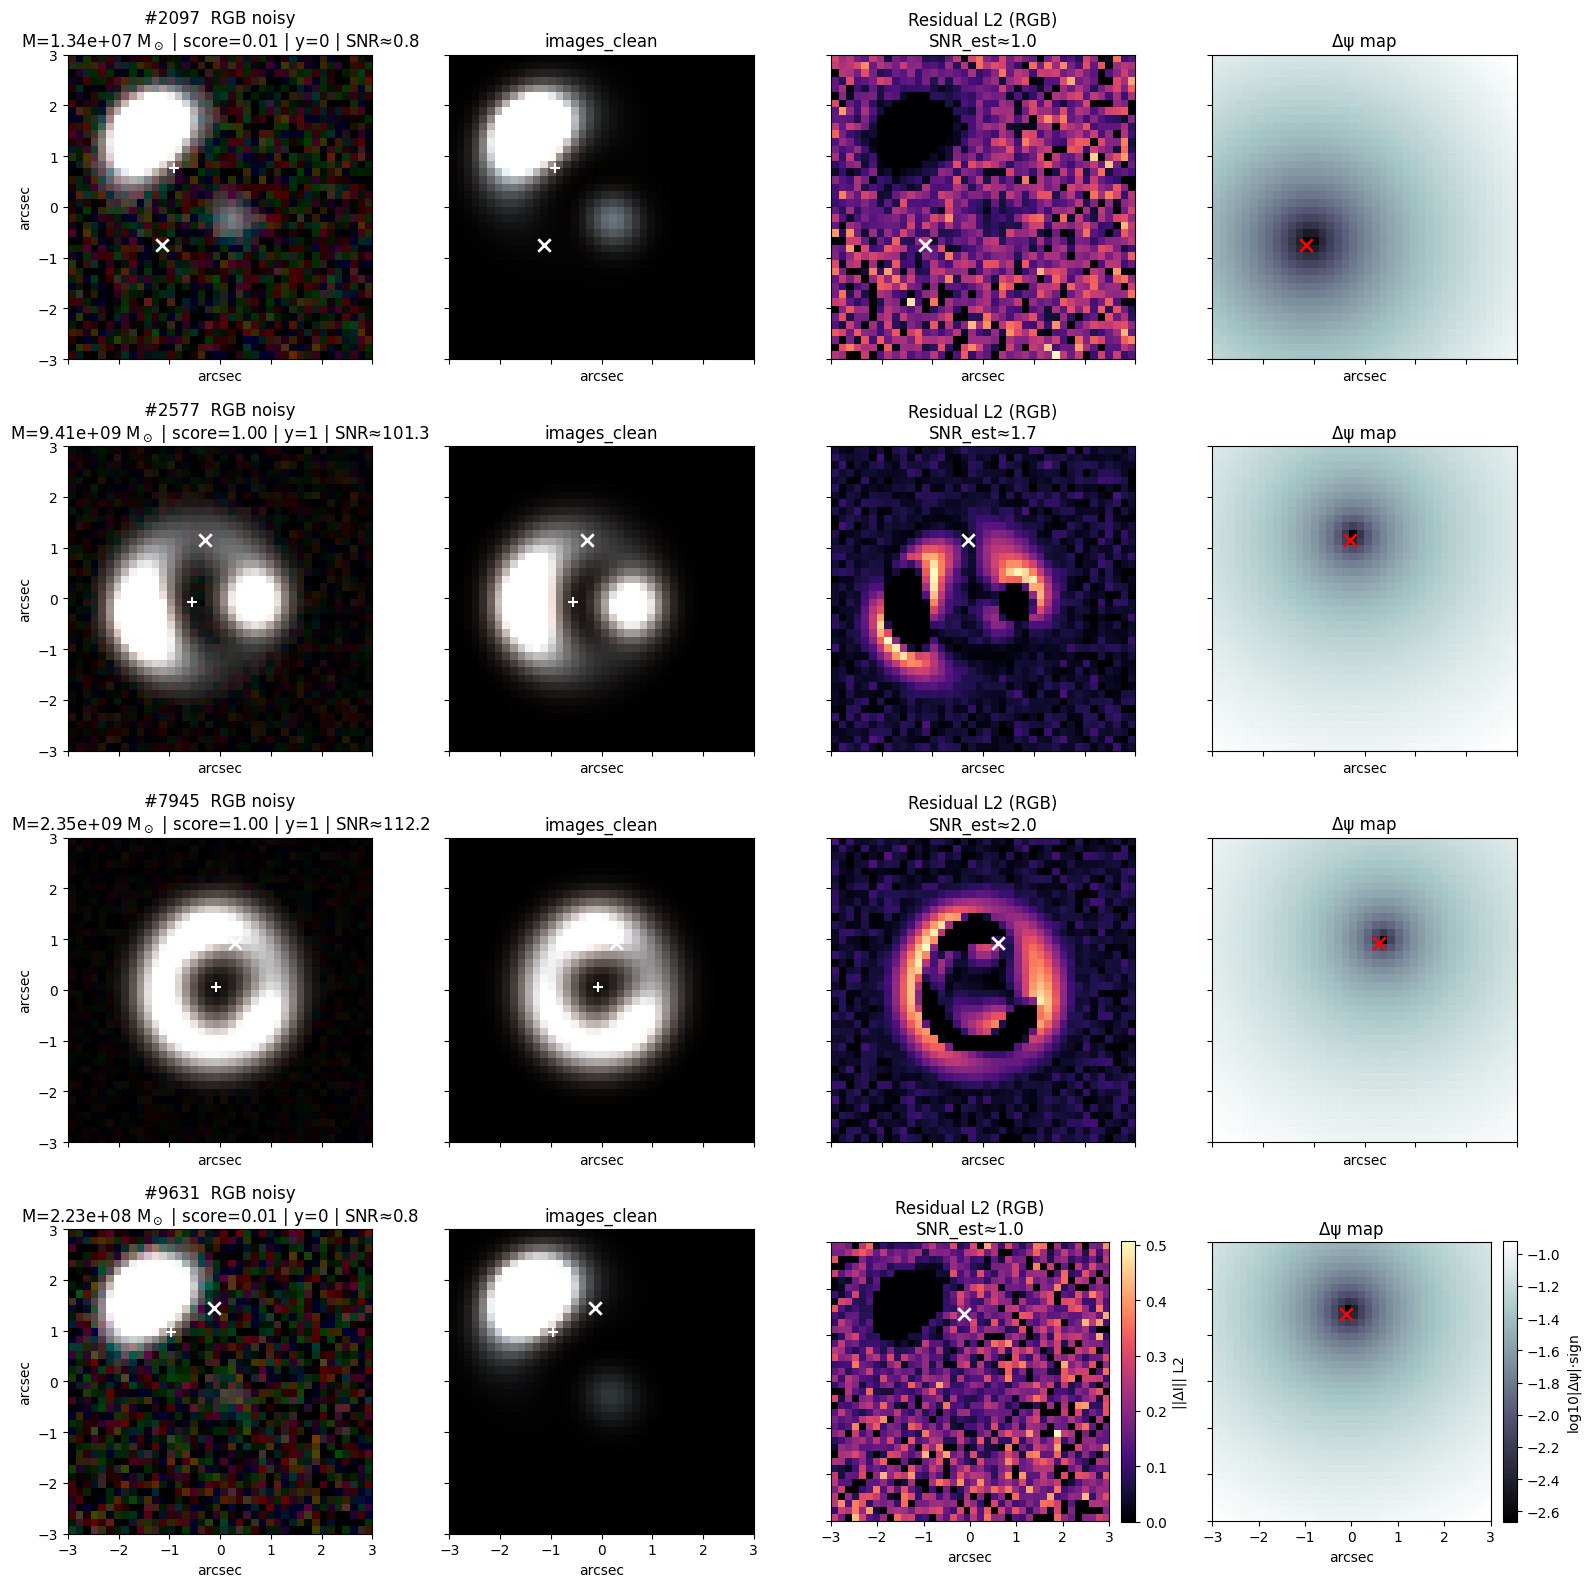


Detectability score (soft) stats: min=0.008, max=1.000, mean=0.410


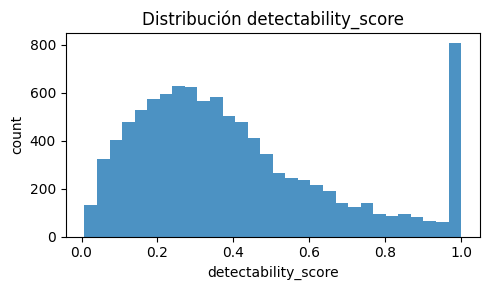

Fracción y_bin=1 (positivos) = 0.767   [is_detectable]


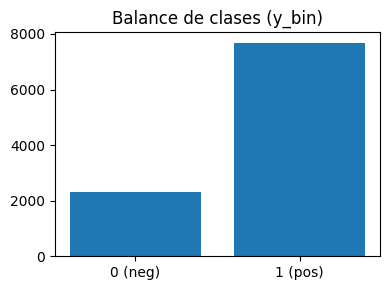

Alineación entre y_soft>=0.5 y y_bin real: acc=0.521 (umbral=0.5)


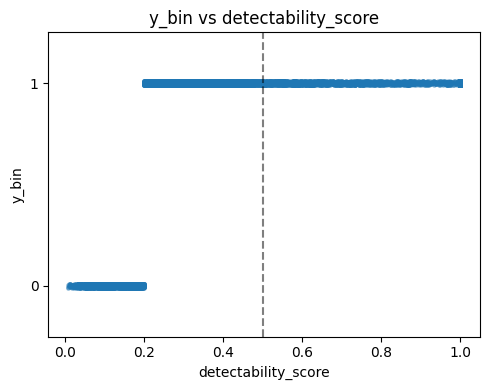

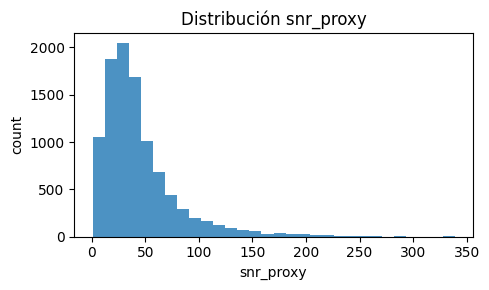

corr(snr_proxy, detectability_score) = 0.920


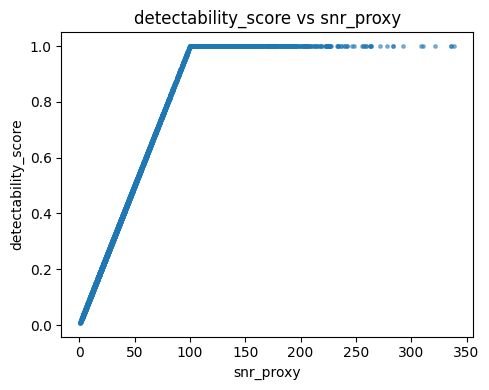

In [15]:
# explore_lsst_lensing_h5 (versión para etiqueta continua)
import numpy as np
import h5py
import matplotlib.pyplot as plt

# =========================
# Helpers
# =========================
def _pick_key(group, *candidates):
    """Devuelve el primer nombre existente en el HDF5 de la lista de candidatos."""
    for k in candidates:
        if k in group:
            return k
    return None

def _pick_attr(attrs, name, default=None, cast=float):
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _get_extent(f):
    """extent=[xmin,xmax,ymin,ymax] (arcsec) para imshow."""
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    # si no hay stamp_size, infiere con pixel_scale
    if 'images_rgb' in f:
        ny, nx = f['images_rgb'].shape[1:3]
    else:
        ny = nx = 40
    ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
    Lx, Ly = nx*ps, ny*ps
    return [-Lx/2, Lx/2, -Ly/2, Ly/2]

def _residual_l2_rgb(img_a, img_b):
    """L2 por píxel en 3 canales (H,W). img_a e img_b deben tener mismo espacio."""
    R = img_a - img_b
    return np.sqrt((R*R).sum(axis=-1))

def _estimate_sigma_from_corners(img_rgb, corner=6):
    """Sigma por banda desde esquinas; sigma_eff para L2 RGB."""
    H, W, C = img_rgb.shape
    c = min(corner, H//4, W//4)
    corners = [img_rgb[:c,:c,:], img_rgb[:c,-c:,:], img_rgb[-c:,:c,:], img_rgb[-c:,-c:,:]]
    stack = np.concatenate([x.reshape(-1, C) for x in corners], axis=0)
    sigma_per_band = np.std(stack, axis=0)
    sigma_eff = float(np.sqrt((sigma_per_band**2).sum()))
    return sigma_per_band, sigma_eff

def _target_soft_and_binary(f):
    """
    Devuelve:
      y_soft in [0,1] si existe (detectability_score / y_soft / score),
      en su defecto None.
      y_bin (0/1) si existe (is_detectable / has_subhalo / label / y),
      en su defecto None.
      además los nombres de las claves usadas.
    """
    ysoft_key = _pick_key(f, 'detectability_score', 'y_soft', 'score')
    ybin_key  = _pick_key(f, 'is_detectable', 'has_subhalo', 'label', 'y')

    y_soft = f[ysoft_key][:].astype(np.float32).ravel() if ysoft_key else None
    y_bin  = f[ybin_key][:].astype(np.int64).ravel()     if ybin_key  else None
    return y_soft, y_bin, ysoft_key, ybin_key

def _pick_clean_like(f):
    """
    Elige un 'clean' compatible con images_rgb para residuales.
      1) 'images_clean' (noisy sin subhalo, semilla A)  <- ideal para residuo emparejado
      2) 'images_no_sub' o 'images_rgb_no_sub'
      3) 'images_clean_noiseless'  (funciona si espacio/escala coincide)
    """
    return _pick_key(f, 'images_clean', 'images_no_sub', 'images_rgb_no_sub', 'images_clean_noiseless')

# =========================
# Explorador con etiqueta continua
# =========================
h5_path = 'LSST_detectability_data.h5'  # <-- ajusta si es otro

with h5py.File(h5_path, 'r') as f:
    # ---- inventario
    print("Available datasets:", list(f.keys()))
    for k in ['images_rgb','images_clean','images_no_sub','images_rgb_no_sub','images_clean_noiseless',
              'delta_psi_maps','subhalo_mass','subhalo_x','subhalo_y',
              'source_x','source_y','snr_proxy','is_detectable','has_subhalo','detectability_score','y_soft','score','vis_mask']:
        if k in f:
            print(f"{k:24s} -> shape {f[k].shape}, dtype {f[k].dtype}")
    print("\nAttributes:")
    for k,v in f.attrs.items():
        print(f" - {k}: {v}")

    # ---- claves principales
    k_rgb   = 'images_rgb'
    k_dpsi  = _pick_key(f, 'delta_psi_maps')
    k_clean = _pick_clean_like(f)
    if k_rgb not in f:
        raise RuntimeError("No encuentro 'images_rgb' en el archivo.")
    X = f[k_rgb]
    N, H, W, C = X.shape

    y_soft, y_bin, ysoft_key, ybin_key = _target_soft_and_binary(f)
    print("\nTargets disponibles:",
          ("y_soft="+ysoft_key) if ysoft_key else "y_soft=None",
          "|",
          ("y_bin="+ybin_key) if ybin_key else "y_bin=None")

    # ---- selección de ejemplos a mostrar
    if y_soft is not None:
        # toma 2 ejemplos con score alto y 2 con score bajo
        order = np.argsort(y_soft)
        lows  = order[:min(2, N)]
        highs = order[::-1][:min(2, N)]
        sample_indices = np.unique(np.concatenate([lows, highs])).astype(int)
        print(f"\nMuestreo estratificado por y_soft: idx={sample_indices.tolist()}")
    elif y_bin is not None:
        idx_pos = np.where(y_bin==1)[0]
        idx_neg = np.where(y_bin==0)[0]
        pick = []
        if idx_pos.size: pick += list(np.random.choice(idx_pos, size=min(2, idx_pos.size), replace=False))
        if idx_neg.size: pick += list(np.random.choice(idx_neg, size=min(2, idx_neg.size), replace=False))
        if not pick:     pick  = list(np.random.choice(np.arange(N), size=4, replace=False))
        sample_indices = np.array(pick)
        print(f"\nMuestreo estratificado por y_bin: idx={sample_indices.tolist()}")
    else:
        sample_indices = np.random.choice(np.arange(N), size=min(4,N), replace=False)
        print(f"\nSin etiquetas: idx={sample_indices.tolist()}")

    # ---- paneles por ejemplo
    extent = _get_extent(f)
    ncols = 1  # RGB
    if k_clean is not None: ncols += 1  # clean
    if k_clean is not None: ncols += 1  # residual
    if k_dpsi  is not None: ncols += 1  # Δψ
    if 'vis_mask' in f:     ncols += 1

    fig, axes = plt.subplots(len(sample_indices), ncols, figsize=(4*ncols, 4*len(sample_indices)),
                             sharex=True, sharey=True)
    if len(sample_indices) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(sample_indices):
        img_rgb = X[idx]  # (H,W,3)
        mass = f['subhalo_mass'][idx] if 'subhalo_mass' in f else np.nan
        x_sub = f['subhalo_x'][idx] if 'subhalo_x' in f else np.nan
        y_sub = f['subhalo_y'][idx] if 'subhalo_y' in f else np.nan
        x_src = f['source_x'][idx] if 'source_x' in f else np.nan
        y_src = f['source_y'][idx] if 'source_y' in f else np.nan
        snr_saved = f['snr_proxy'][idx] if 'snr_proxy' in f else np.nan

        score_txt = f"score={y_soft[idx]:.2f}" if y_soft is not None else ""
        bin_txt   = f"y={int(y_bin[idx])}" if y_bin is not None else ""
        info_lbl  = " | ".join(x for x in [score_txt, bin_txt] if x)

        col = 0
        # 1) RGB noisy
        ax = axes[row, col]; col += 1
        ax.imshow(img_rgb, origin='lower', extent=extent)
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], marker='+', s=60, lw=1.5, color='w')
        tit = f"#{idx}  RGB noisy\nM={mass:.2e} M$_\\odot$"
        if info_lbl: tit += f" | {info_lbl}"
        if np.isfinite(snr_saved): tit += f" | SNR≈{snr_saved:.1f}"
        ax.set_title(tit); ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # 2) clean (si existe)
        img_clean = None
        if k_clean is not None:
            img_clean = f[k_clean][idx]
            ax = axes[row, col]; col += 1
            ax.imshow(img_clean, origin='lower', extent=extent)
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
            if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], marker='+', s=60, lw=1.5, color='w')
            ax.set_title(f"{k_clean}"); ax.set_xlabel("arcsec")

        # 3) residual L2 (si clean disponible y misma escala)
        if img_clean is not None and img_clean.shape == img_rgb.shape:
            R2 = _residual_l2_rgb(img_rgb, img_clean)
            _, sigma_eff = _estimate_sigma_from_corners(img_rgb)
            snr_est = float(np.nanmean(R2) / (sigma_eff + 1e-12))
            ax = axes[row, col]; col += 1
            imR = ax.imshow(R2, origin='lower', extent=extent, cmap='magma')
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
            ax.set_title(f"Residual L2 (RGB)\nSNR_est≈{snr_est:.1f}")
            ax.set_xlabel("arcsec")
            if row == len(sample_indices)-1:
                cbar = plt.colorbar(imR, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel("||ΔI|| L2")

        # 4) Δψ (si existe)
        if k_dpsi is not None:
            dpsi = f[k_dpsi][idx]
            ax = axes[row, col]; col += 1
            im = ax.imshow(dpsi, origin='lower', extent=extent, cmap='bone')
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='r')
            ax.set_title("Δψ map"); ax.set_xlabel("arcsec")
            if row == len(sample_indices)-1:
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel("log10|Δψ|·sign")

        # 5) vis_mask (si existe)
        if 'vis_mask' in f:
            vis = f['vis_mask'][idx]
            ax = axes[row, col]; col += 1
            ax.imshow(vis, origin='lower', extent=extent, cmap='viridis')
            ax.set_title("vis_mask"); ax.set_xlabel("arcsec")

    plt.tight_layout(); plt.show()

    # =========================
    # Diagnósticos globales
    # =========================
    if y_soft is not None:
        print(f"\nDetectability score (soft) stats: min={y_soft.min():.3f}, max={y_soft.max():.3f}, mean={y_soft.mean():.3f}")
        plt.figure(figsize=(5,3))
        plt.hist(y_soft, bins=30, alpha=.8)
        plt.xlabel("detectability_score"); plt.ylabel("count")
        plt.title("Distribución detectability_score"); plt.tight_layout(); plt.show()

    if y_bin is not None:
        frac = y_bin.mean()
        print(f"Fracción y_bin=1 (positivos) = {frac:.3f}   [{ybin_key}]")
        plt.figure(figsize=(4,3))
        counts = [np.sum(y_bin==0), np.sum(y_bin==1)]
        plt.bar([0,1], counts, tick_label=['0 (neg)','1 (pos)'])
        plt.title("Balance de clases (y_bin)"); plt.tight_layout(); plt.show()

    # Relación entre y_soft y y_bin (si existen ambos)
    if (y_soft is not None) and (y_bin is not None):
        thr_default = 0.5
        y_bin_from_soft = (y_soft >= thr_default).astype(int)
        acc = (y_bin_from_soft == y_bin).mean()
        print(f"Alineación entre y_soft>=0.5 y y_bin real: acc={acc:.3f} (umbral=0.5)")
        plt.figure(figsize=(5,4))
        jitter = (np.random.rand(N)-0.5)*0.02
        plt.scatter(y_soft, y_bin + jitter, s=6, alpha=.4)
        plt.axvline(thr_default, ls='--', c='k', alpha=.5)
        plt.yticks([0,1]); plt.ylim(-0.25,1.25)
        plt.xlabel("detectability_score"); plt.ylabel("y_bin")
        plt.title("y_bin vs detectability_score"); plt.tight_layout(); plt.show()

    # SNR proxy (si existe)
    if 'snr_proxy' in f:
        snr = f['snr_proxy'][:]
        plt.figure(figsize=(5,3))
        plt.hist(snr, bins=30, alpha=.8)
        plt.xlabel("snr_proxy"); plt.ylabel("count")
        plt.title("Distribución snr_proxy"); plt.tight_layout(); plt.show()
        if y_soft is not None:
            # correlación simple
            corr = np.corrcoef(snr, y_soft)[0,1]
            print(f"corr(snr_proxy, detectability_score) = {corr:.3f}")
            plt.figure(figsize=(5,4))
            plt.scatter(snr, y_soft, s=6, alpha=.5)
            plt.xlabel("snr_proxy"); plt.ylabel("detectability_score")
            plt.title("detectability_score vs snr_proxy"); plt.tight_layout(); plt.show()


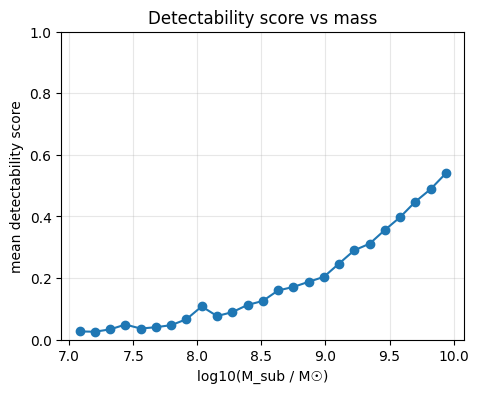

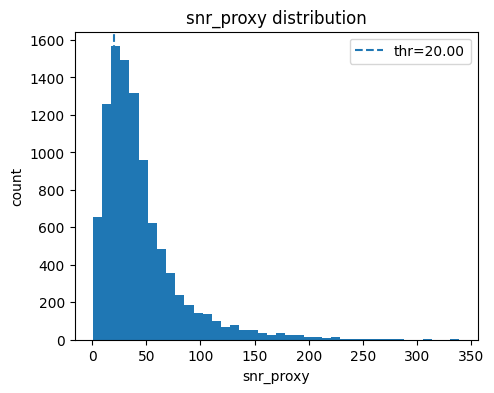

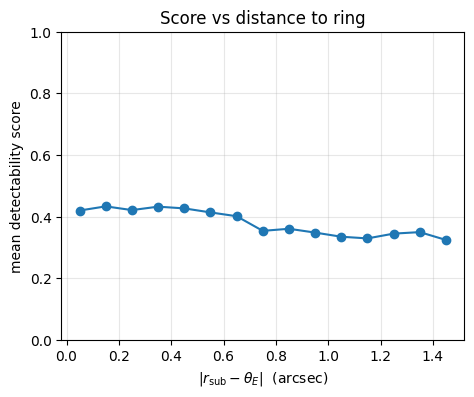

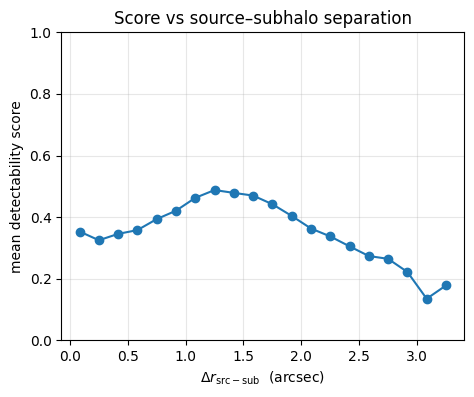

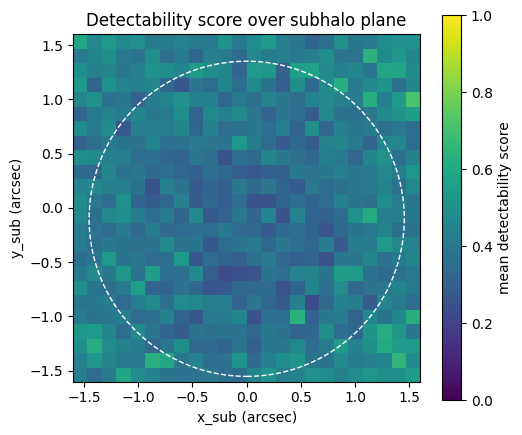

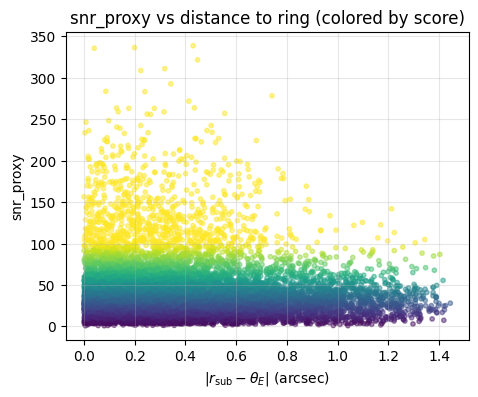

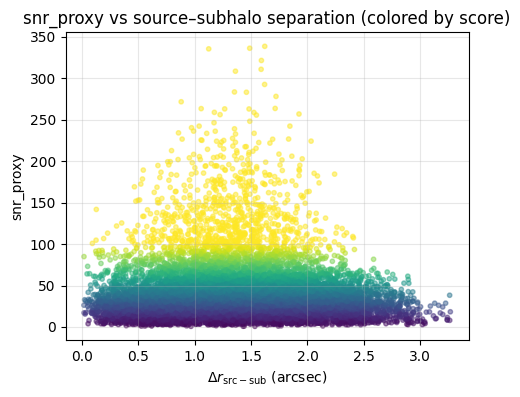

Corr(score, |r_sub - theta_E|) = -0.0957760140299797
Corr(score, snr)               = 0.919680655002594
Corr(score, Δr_src-sub)        = -0.05938233807682991
Corr(score, log10(M))          = 0.45341044664382935


In [16]:
import numpy as np, h5py, matplotlib.pyplot as plt

# ====== archivo ======
h5_path = 'LSST_detectability_data.h5'

def _pick_key(group, *cands):
    for k in cands:
        if k in group: return k
    return None

# ---- Cargar arrays y attrs ----
with h5py.File(h5_path, 'r') as f:
    m    = f['subhalo_mass'][:]                     if 'subhalo_mass' in f else None
    snr  = f['snr_proxy'][:]                        if 'snr_proxy'     in f else None
    xs   = f['subhalo_x'][:]                        if 'subhalo_x'     in f else None
    ys   = f['subhalo_y'][:]                        if 'subhalo_y'     in f else None
    xq   = f['source_x'][:] if 'source_x' in f else np.full_like(xs, np.nan) if xs is not None else None
    yq   = f['source_y'][:] if 'source_y' in f else np.full_like(ys, np.nan) if ys is not None else None

    # Etiqueta continua preferente
    ysoft_key = _pick_key(f, 'detectability_score', 'y_soft', 'score')
    y_soft = f[ysoft_key][:].astype(np.float32).ravel() if ysoft_key else None

    # Fallback binario (por si no existe score)
    ybin_key = _pick_key(f, 'is_detectable', 'has_subhalo', 'label', 'y')
    y_bin = f[ybin_key][:].astype(bool).ravel() if ybin_key else None

    # Si no hay y_soft, lo fabricamos desde binario (0/1)
    if y_soft is None and y_bin is not None:
        y_soft = y_bin.astype(np.float32)

    # theta_E y umbral SNR (opcional)
    theta_E = float(f.attrs.get('theta_E_main', 1.452))
    snr_thr = float(f.attrs.get('snr_thresh_noisy', np.nan))

# ====== Comprobaciones mínimas ======
assert y_soft is not None, "No continuous target found (detectability_score/y_soft/score, ni binario)."

# ====== features geométricas ======
qmass = np.log10(np.clip(m, 1, None)) if m is not None else None
r_sub = np.hypot(xs, ys)              if xs is not None else None
r_src = np.hypot(xq, yq)              if xq is not None else None
dr_src_sub  = np.hypot(xs - xq, ys - yq) if (xs is not None and xq is not None) else None
dr_sub_ring = np.abs(r_sub - theta_E)    if r_sub is not None else None

# ====== helper para promedio binned ======
def mean_binned(x, y, bins):
    mids, mu, n = [], [], []
    sel0 = np.isfinite(y)
    for a, b in zip(bins[:-1], bins[1:]):
        sel = sel0 & np.isfinite(x) & (x >= a) & (x < b)
        if sel.sum():
            mids.append((a + b) / 2)
            mu.append(y[sel].mean())
            n.append(sel.sum())
    return np.array(mids), np.array(mu), np.array(n)

# ====== 1) ⟨score | masa⟩ ======
if qmass is not None:
    bins_mass = np.linspace(max(4, np.nanmin(qmass)), min(10, np.nanmax(qmass)), 26)
    mids, mu, cnt = mean_binned(qmass, y_soft, bins_mass)
    plt.figure(figsize=(5.2,4))
    plt.plot(mids, mu, marker='o')
    plt.ylim(0,1); plt.grid(True, alpha=.3)
    plt.xlabel('log10(M_sub / M☉)'); plt.ylabel('mean detectability score')
    plt.title('Detectability score vs mass'); plt.show()

# ====== 2) Hist de SNR (si existe) ======
if snr is not None:
    plt.figure(figsize=(5.2,4))
    plt.hist(snr[np.isfinite(snr)], bins=40)
    if np.isfinite(snr_thr): plt.axvline(snr_thr, ls='--', label=f'thr={snr_thr:.2f}')
    plt.xlabel('snr_proxy'); plt.ylabel('count'); 
    plt.title('snr_proxy distribution'); 
    if np.isfinite(snr_thr): plt.legend()
    plt.show()

# ====== 3) ⟨score ||r_sub - theta_E|⟩ ======
if dr_sub_ring is not None:
    bins_ring = np.linspace(0, max(2.0, np.nanmax(dr_sub_ring)), 21)
    mids, mu, cnt = mean_binned(dr_sub_ring, y_soft, bins_ring)
    plt.figure(figsize=(5.2,4))
    plt.plot(mids, mu, marker='o')
    plt.ylim(0,1); plt.grid(True, alpha=.3)
    plt.xlabel(r'$|r_{\rm sub}-\theta_E|$  (arcsec)')
    plt.ylabel('mean detectability score')
    plt.title('Score vs distance to ring'); 
    plt.show()

# ====== 4) ⟨score | Δr_src-sub⟩ ======
if dr_src_sub is not None and np.isfinite(dr_src_sub).any():
    bins_sep = np.linspace(0, max(4.0, np.nanmax(dr_src_sub)), 25)
    mids, mu, cnt = mean_binned(dr_src_sub, y_soft, bins_sep)
    plt.figure(figsize=(5.2,4))
    plt.plot(mids, mu, marker='o')
    plt.ylim(0,1); plt.grid(True, alpha=.3)
    plt.xlabel(r'$\Delta r_{\rm src-sub}$  (arcsec)')
    plt.ylabel('mean detectability score')
    plt.title('Score vs source–subhalo separation'); 
    plt.show()

# ====== 5) Mapa 2D de ⟨score⟩ en (x_sub,y_sub) ======
if xs is not None and ys is not None:
    xb = np.linspace(np.nanmin(xs), np.nanmax(xs), 25)
    yb = np.linspace(np.nanmin(ys), np.nanmax(ys), 25)
    H_sum   = np.zeros((len(yb)-1, len(xb)-1), dtype=float)
    H_count = np.zeros_like(H_sum)
    ix = np.digitize(xs, xb) - 1
    iy = np.digitize(ys, yb) - 1
    valid = (ix>=0)&(ix<H_sum.shape[1])&(iy>=0)&(iy<H_sum.shape[0])&np.isfinite(y_soft)
    for i, j, s in zip(iy[valid], ix[valid], y_soft[valid]):
        H_count[i,j] += 1
        H_sum[i,j]   += float(s)
    P2 = np.where(H_count>0, H_sum/H_count, np.nan)

    plt.figure(figsize=(5.6,5))
    im = plt.imshow(P2, origin='lower',
                    extent=[xb[0], xb[-1], yb[0], yb[-1]],
                    vmin=0, vmax=1, cmap='viridis')
    plt.colorbar(im, label='mean detectability score')
    plt.xlabel('x_sub (arcsec)'); plt.ylabel('y_sub (arcsec)')
    plt.title('Detectability score over subhalo plane')
    circle = plt.Circle((0.0,-0.1), theta_E, color='w', fill=False, lw=1, ls='--')
    plt.gca().add_patch(circle)
    plt.show()

# ====== 6) Dispersión score vs métricas geométricas ======
def _scatter_xy(x, y, c, xlabel, ylabel, title):
    sel = np.isfinite(x) & np.isfinite(c)
    plt.figure(figsize=(5.2,4))
    plt.scatter(x[sel], y[sel], s=10, alpha=0.5, c=c[sel], cmap='viridis', vmin=0, vmax=1)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title); plt.grid(True, alpha=.3); plt.show()

if dr_sub_ring is not None and snr is not None:
    _scatter_xy(dr_sub_ring, snr, y_soft, r'$|r_{\rm sub}-\theta_E|$ (arcsec)', 'snr_proxy',
                'snr_proxy vs distance to ring (colored by score)')

if dr_src_sub is not None and snr is not None:
    _scatter_xy(dr_src_sub, snr, y_soft, r'$\Delta r_{\rm src-sub}$ (arcsec)', 'snr_proxy',
                'snr_proxy vs source–subhalo separation (colored by score)')

# ====== 7) Correlaciones rápidas (con score) ======
def corr(a,b):
    sel = np.isfinite(a) & np.isfinite(b)
    if sel.sum() < 3: return np.nan
    aa, bb = a[sel], b[sel]
    aa = (aa - aa.mean())/(aa.std()+1e-12)
    bb = (bb - bb.mean())/(bb.std()+1e-12)
    return float(np.mean(aa*bb))

if snr is not None and dr_sub_ring is not None:
    print("Corr(score, |r_sub - theta_E|) =", corr(y_soft, dr_sub_ring))
    print("Corr(score, snr)               =", corr(y_soft, snr))
if dr_src_sub is not None:
    print("Corr(score, Δr_src-sub)        =", corr(y_soft, dr_src_sub))
if qmass is not None:
    print("Corr(score, log10(M))          =", corr(y_soft, qmass))


In [17]:
# === Continuous-target dataset prep (detectability_score) ===
import h5py, numpy as np, torch
from sklearn.model_selection import train_test_split

# ---------- Config ----------
H5_PATH = 'LSST_detectability_data.h5'   # pon aquí tu archivo .h5 actual
RANDOM_STATE = 42
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.6, 0.2, 0.2
N_BINS_STRATIFY = 10   # nº de bins para estratificar por score continuo

assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6
rng = np.random.default_rng(RANDOM_STATE)

# ---------- Carga ----------
with h5py.File(H5_PATH, "r") as f:
    X = f["images_rgb"][:]                               # (N,H,W,3)
    # target continuo en [0,1]
    if "detectability_score" in f:
        y_soft = f["detectability_score"][:].astype(np.float32).ravel()
    else:
        # fallback: normaliza snr_proxy/100 si fuese necesario
        y_soft = (f["snr_proxy"][:] / 100.0).astype(np.float32).ravel()
        y_soft = np.clip(y_soft, 0.0, 1.0)

    # (opcional) útil si quieres comparar binario luego
    y_bin = f["is_detectable"][:].astype(np.int64).ravel() if "is_detectable" in f else None

print("X raw:", X.shape, X.dtype, "| y_soft:", y_soft.shape, y_soft.dtype,
      f"| y_bin: {None if y_bin is None else y_bin.shape}")

# ---------- Normalización y formato (C,H,W) ----------
# Las imágenes suelen venir sqrt-stretched ~[0,1]. Si no, normalizamos con p99.5 por canal.
X = X.astype(np.float32)
mx = X.max()
if mx > 1.5:  # parece no estar en [0,1]
    p = np.percentile(X.reshape(-1, X.shape[-1]), 99.5, axis=0).astype(np.float32)  # (3,)
    p[p <= 1e-6] = 1.0
    X = X / p[None, None, None, :]
X = np.transpose(X, (0, 3, 1, 2))  # (N,3,H,W)

# ---------- Split estratificado por bins del target continuo ----------
# Bineamos y_soft para poder usar "stratify"
edges = np.linspace(0.0, 1.0, N_BINS_STRATIFY + 1)
y_bins = np.digitize(y_soft, edges[:-1], right=False) - 1  # 0..N_BINS-1
y_bins = np.clip(y_bins, 0, N_BINS_STRATIFY - 1)

idx_all = np.arange(len(y_soft))
idx_train, idx_rest, y_bins_train, y_bins_rest = train_test_split(
    idx_all, y_bins, test_size=(1.0 - TRAIN_FRAC),
    stratify=y_bins, random_state=RANDOM_STATE
)

val_size = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
idx_val, idx_test, y_bins_val, y_bins_test = train_test_split(
    idx_rest, y_bins_rest, test_size=(1.0 - val_size),
    stratify=y_bins_rest, random_state=RANDOM_STATE
)

# ---------- Tensores listos ----------
X_train = torch.tensor(X[idx_train], dtype=torch.float32)
X_val   = torch.tensor(X[idx_val],   dtype=torch.float32)
X_test  = torch.tensor(X[idx_test],  dtype=torch.float32)

y_train = torch.tensor(y_soft[idx_train], dtype=torch.float32)  # (N,)
y_val   = torch.tensor(y_soft[idx_val],   dtype=torch.float32)
y_test  = torch.tensor(y_soft[idx_test],  dtype=torch.float32)

# (opcional) también guardo los binarios si estaban en el archivo (útil para análisis)
ybin_train = torch.tensor(y_bin[idx_train], dtype=torch.int64) if y_bin is not None else None
ybin_val   = torch.tensor(y_bin[idx_val],   dtype=torch.int64) if y_bin is not None else None
ybin_test  = torch.tensor(y_bin[idx_test],  dtype=torch.int64) if y_bin is not None else None

print("Splits:")
print(f"  train: {len(idx_train)} | val: {len(idx_val)} | test: {len(idx_test)}")
print("Tensors:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "| y_val:",   y_val.shape)
print("  X_test: ", X_test.shape,  "| y_test:",  y_test.shape)
if y_bin is not None:
    print(f"  (binarios) train pos={int(ybin_train.sum())} / {len(ybin_train)}")

# ---------- Guardar índices del split (por reproducibilidad) ----------
np.savez_compressed(
    H5_PATH.replace(".h5", "_split_idx_continuous.npz"),
    train=idx_train, val=idx_val, test=idx_test,
    edges=edges
)


X raw: (10000, 40, 40, 3) float32 | y_soft: (10000,) float32 | y_bin: (10000,)
Splits:
  train: 6000 | val: 2000 | test: 2000
Tensors:
  X_train: torch.Size([6000, 3, 40, 40]) | y_train: torch.Size([6000])
  X_val:   torch.Size([2000, 3, 40, 40]) | y_val: torch.Size([2000])
  X_test:  torch.Size([2000, 3, 40, 40]) | y_test: torch.Size([2000])
  (binarios) train pos=4604 / 6000


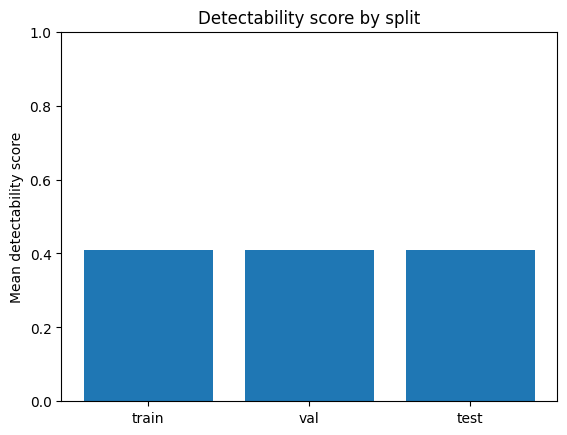

Fraction >= 0.5  ->  train 0.288 | val 0.289 | test 0.288
Fraction >= 0.7  ->  train 0.157 | val 0.157 | test 0.157


In [18]:
import matplotlib.pyplot as plt
import torch

# Aseguramos tensores float
y_train_f = y_train.float()
y_val_f   = y_val.float()
y_test_f  = y_test.float()

# Promedio del score por split
m_train = y_train_f.mean().item()
m_val   = y_val_f.mean().item()
m_test  = y_test_f.mean().item()

plt.bar(['train', 'val', 'test'], [m_train, m_val, m_test])
plt.ylabel("Mean detectability score")
plt.ylim(0, 1)
plt.title("Detectability score by split")
plt.show()

# (Opcional) fracciones sobre umbrales para inspección rápida
for thr in (0.5, 0.7):
    ft = (y_train_f >= thr).float().mean().item()
    fv = (y_val_f   >= thr).float().mean().item()
    fs = (y_test_f  >= thr).float().mean().item()
    print(f"Fraction >= {thr:.1f}  ->  train {ft:.3f} | val {fv:.3f} | test {fs:.3f}")



In [19]:

# import torch
# from torch.utils.data import Dataset
# import h5py

# class LensingDataset(Dataset):
#     def __init__(self, h5_path, indices, transform=None):
#         self.h5_path = h5_path
#         self.indices = indices
#         self.transform = transform

#         # Abrimos el archivo en modo de solo lectura
#         self.file = h5py.File(self.h5_path, 'r')
#         self.X = self.file['images_rgb']
#         self.y = self.file['is_detectable']

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         real_idx = self.indices[idx]
#         img = self.X[real_idx]        # (H,W,3)
#         label = self.y[real_idx]      # 0 o 1

#         # Normalización simple
#         img = img.astype('float32') / self.X.attrs.get('maxval', 1.0)
#         img = img.transpose(2, 0, 1)  # PyTorch: (C, H, W)

#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         label_tensor = torch.tensor(label, dtype=torch.float32)

#         return img_tensor, label_tensor

#     def close(self):
#         self.file.close()


In [20]:
# import numpy as np
# from torch.utils.data import DataLoader

# # ---------- Config ----------
# h5_path = 'LSST_Mmxy_noisyResidual_paired_withNoSub.h5'
# split_path = h5_path.replace('.h5', '_split_idx.npz')
# batch_size = 32

# # ---------- Cargar índices ----------
# splits = np.load(split_path)
# idx_train = splits['train']
# idx_val   = splits['val']
# idx_test  = splits['test']

# # ---------- Instanciar datasets ----------
# ds_train = LensingDataset(h5_path, idx_train)
# ds_val   = LensingDataset(h5_path, idx_val)
# ds_test  = LensingDataset(h5_path, idx_test)

# # ---------- Crear DataLoaders ----------
# dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
# dl_val   = DataLoader(ds_val, batch_size=batch_size)
# dl_test  = DataLoader(ds_test, batch_size=batch_size)

from torch.utils.data import TensorDataset, DataLoader
import torch

# ---------- Config ----------
batch_size = 128
on_cuda = torch.cuda.is_available()

# Asegura forma (B,1) para regresión
y_train_reg = y_train.view(-1, 1).float()
y_val_reg   = y_val.view(-1, 1).float()
y_test_reg  = y_test.view(-1, 1).float()

# ---------- TensorDatasets ----------
train_ds = TensorDataset(X_train, y_train_reg)
val_ds   = TensorDataset(X_val,   y_val_reg)
test_ds  = TensorDataset(X_test,  y_test_reg)

# ---------- DataLoader configs ----------
loader_kwargs = dict(
    batch_size=batch_size,
    num_workers=2 if on_cuda else 0,
    pin_memory=on_cuda,
    persistent_workers=on_cuda and (2 > 0)
)

# ---------- DataLoaders ----------
dl_train = DataLoader(train_ds, shuffle=True,  drop_last=True,  **loader_kwargs)
dl_val   = DataLoader(val_ds,   shuffle=False, drop_last=False, **loader_kwargs)
dl_test  = DataLoader(test_ds,  shuffle=False, drop_last=False, **loader_kwargs)

print("Loaders OK ->",
      f"train {len(dl_train)} batches,",
      f"val {len(dl_val)} batches,",
      f"test {len(dl_test)} batches")


Loaders OK -> train 46 batches, val 16 batches, test 16 batches


In [21]:
# ========================
# Modelo (salida (B,1))
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    """
    Igual que antes, pero devolvemos (B,1) para regresión continua.
    """
    def __init__(self, p_drop=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2, 2)  # 40->20->10->5 tras 3 pools
        self.drop1 = nn.Dropout2d(p_drop)
        self.drop2 = nn.Dropout2d(p_drop)

        self.gap   = nn.AdaptiveAvgPool2d(1)  # -> (B,128,1,1)
        self.fc    = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 40->20
        x = self.drop1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 20->10
        x = self.drop2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 10->5
        x = self.gap(x).flatten(1)                      # (B,128)
        x = torch.sigmoid(self.fc(x))                   # (B,1) en [0,1]
        return x


Entrenando en: cuda


Epoch: 100%|█| 100/100 [00:41<00:00,  2.42it/s, acc_bin=0.906, f1_bin=0.664, mae=0.116, rmse=0.151, tr_loss=0.0227, v_loss=0.0227]


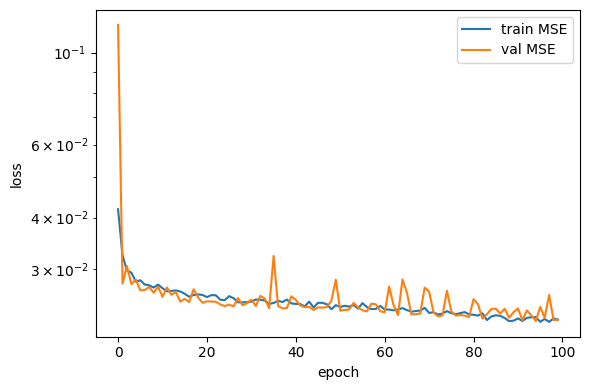

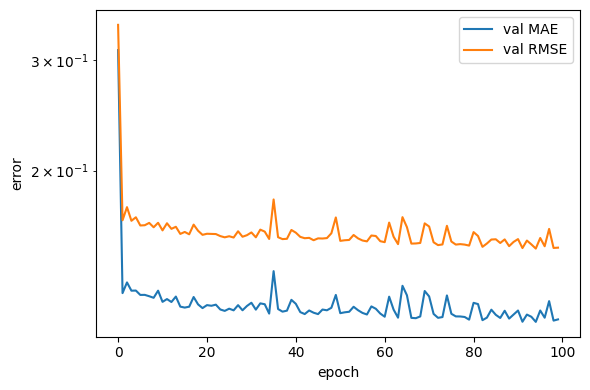

Test  MAE=0.1133   RMSE=0.1482
[bin@0.70]  acc=0.915  prec=0.768  rec=0.662  f1=0.711


In [22]:
# ========================
# Entrenamiento (regresión)
# ========================
import torch
import torch.nn as nn
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt

# Usa los dataloaders ya creados: dl_train, dl_val, dl_test
# y tensores target en forma (B,1): y_train_reg, y_val_reg, y_test_reg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

model = SimpleCNN().to(device)

# Criterio principal para regresión
criterion = nn.MSELoss()        # también puedes probar nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 100

# (Opcional) diagnóstico como clasificador con umbral:
BIN_THR = 0.7

def _bin_metrics(y_true, y_pred, thr=0.5):
    """
    Métricas binarias sobre la marcha (diagnóstico).
    y_true, y_pred en forma (N,1) o (N,)
    """
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    yb_t = (y_true >= thr).astype(np.int32)
    yb_p = (y_pred >= thr).astype(np.int32)
    acc = (yb_t == yb_p).mean()
    tp = np.sum((yb_t==1) & (yb_p==1))
    fp = np.sum((yb_t==0) & (yb_p==1))
    fn = np.sum((yb_t==1) & (yb_p==0))
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    return acc, prec, rec, f1

train_loss_hist, val_loss_hist = [], []
val_mae_hist, val_rmse_hist = [], []

outer_bar = trange(1, epochs+1, desc="Epoch", ncols=130, colour="#EB5E00")
best_state, best_val = None, np.inf

for ep in outer_bar:
    # ---- Train ----
    model.train()
    run_loss = 0.0
    for xb, yb in dl_train:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        out = model(xb)              # (B,1) en [0,1]
        loss = criterion(out, yb)    # MSE sobre score
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * xb.size(0)

    tr_loss = run_loss / (len(dl_train.dataset))
    train_loss_hist.append(tr_loss)

    # ---- Val ----
    model.eval()
    v_loss = 0.0
    preds, targs = [], []
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            out = model(xb)
            loss = criterion(out, yb)
            v_loss += loss.item() * xb.size(0)
            preds.append(out.cpu().numpy())
            targs.append(yb.cpu().numpy())

    v_loss /= len(dl_val.dataset)
    val_loss_hist.append(v_loss)

    yv = np.concatenate(targs, axis=0)  # (N,1)
    pv = np.concatenate(preds, axis=0)  # (N,1)
    mae = np.mean(np.abs(pv - yv))
    rmse = np.sqrt(np.mean((pv - yv)**2))
    val_mae_hist.append(mae); val_rmse_hist.append(rmse)

    # Métricas binarias de diagnóstico @ BIN_THR
    acc, prec, rec, f1 = _bin_metrics(yv, pv, thr=BIN_THR)

    # Early-stopping simple por MSE de validación
    if v_loss < best_val:
        best_val = v_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    outer_bar.set_postfix(
        tr_loss=f"{tr_loss:.4f}",
        v_loss=f"{v_loss:.4f}",
        mae=f"{mae:.3f}",
        rmse=f"{rmse:.3f}",
        acc_bin=f"{acc:.3f}",
        f1_bin=f"{f1:.3f}"
    )

# ---- Cargar mejor estado y graficar curvas ----
if best_state is not None:
    model.load_state_dict(best_state)

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="train MSE")
plt.plot(val_loss_hist,   label="val MSE")
plt.yscale("log")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_mae_hist,  label="val MAE")
plt.plot(val_rmse_hist, label="val RMSE")
plt.yscale("log")
plt.xlabel("epoch"); plt.ylabel("error"); plt.legend(); plt.tight_layout(); plt.show()

# ---- Evaluación final en test ----
model.eval()
preds, targs = [], []
with torch.no_grad():
    for xb, yb in dl_test:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        out = model(xb)
        preds.append(out.cpu().numpy())
        targs.append(yb.cpu().numpy())

yt = np.concatenate(targs, axis=0)
pt = np.concatenate(preds, axis=0)
test_mae  = np.mean(np.abs(pt - yt))
test_rmse = np.sqrt(np.mean((pt - yt)**2))
print(f"Test  MAE={test_mae:.4f}   RMSE={test_rmse:.4f}")

# (Opcional) diagnóstico binario @ BIN_THR sobre test
acc, prec, rec, f1 = _bin_metrics(yt, pt, thr=BIN_THR)
print(f"[bin@{BIN_THR:.2f}]  acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}")


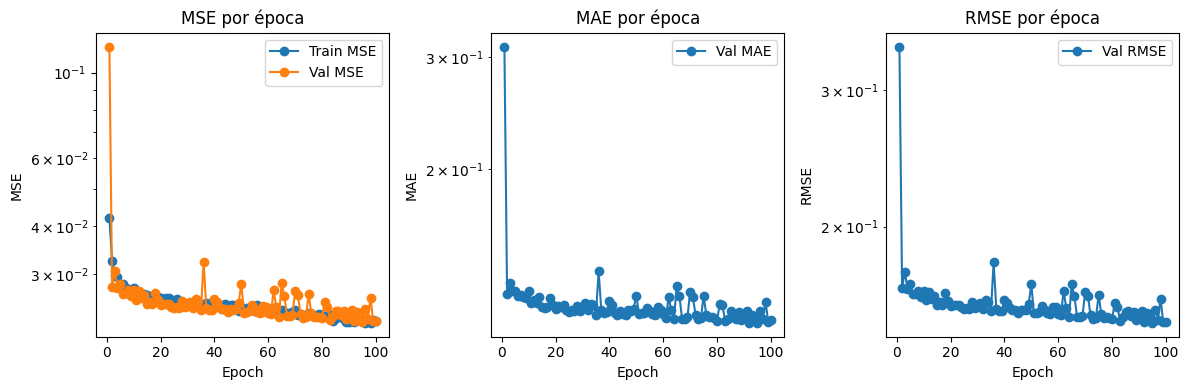

In [23]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(1, len(train_loss_hist)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs_range, train_loss_hist, label='Train MSE', marker='o')
plt.plot(epochs_range, val_loss_hist,   label='Val MSE',   marker='o')
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("MSE por época"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs_range, val_mae_hist,  label='Val MAE',  marker='o')
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("MAE por época"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs_range, val_rmse_hist, label='Val RMSE', marker='o')
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.title("RMSE por época"); plt.legend()

plt.tight_layout(); plt.show()


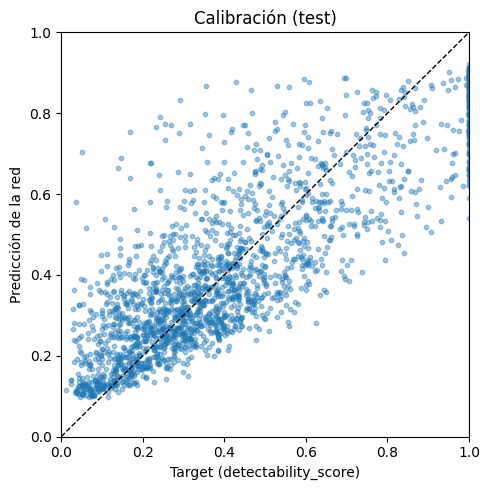

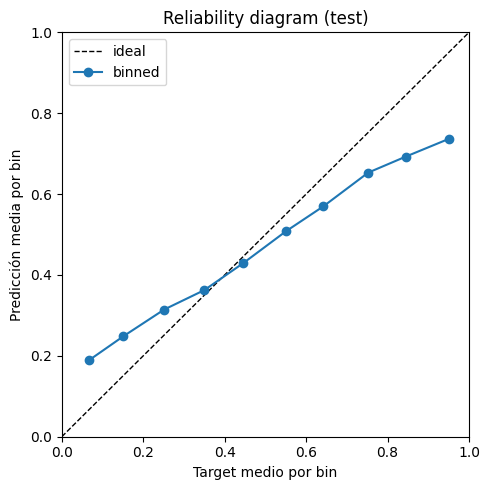

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# yt, pt vienen de la celda de evaluación (shapes (N,1) o (N,))
yt_flat = yt.reshape(-1)
pt_flat = pt.reshape(-1)

plt.figure(figsize=(5,5))
plt.scatter(yt_flat, pt_flat, s=10, alpha=0.4)
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Target (detectability_score)")
plt.ylabel("Predicción de la red")
plt.title("Calibración (test)")
plt.tight_layout(); plt.show()

# Binned calibration (fiabilidad)
bins = np.linspace(0,1,11)
centers, y_mean, p_mean = [], [], []
for a,b in zip(bins[:-1], bins[1:]):
    sel = (yt_flat>=a)&(yt_flat<b)
    if np.any(sel):
        centers.append(0.5*(a+b))
        y_mean.append(yt_flat[sel].mean())
        p_mean.append(pt_flat[sel].mean())

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--',lw=1,label='ideal')
if len(centers):
    plt.plot(y_mean, p_mean, 'o-', label='binned')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Target medio por bin")
plt.ylabel("Predicción media por bin")
plt.title("Reliability diagram (test)")
plt.legend(); plt.tight_layout(); plt.show()


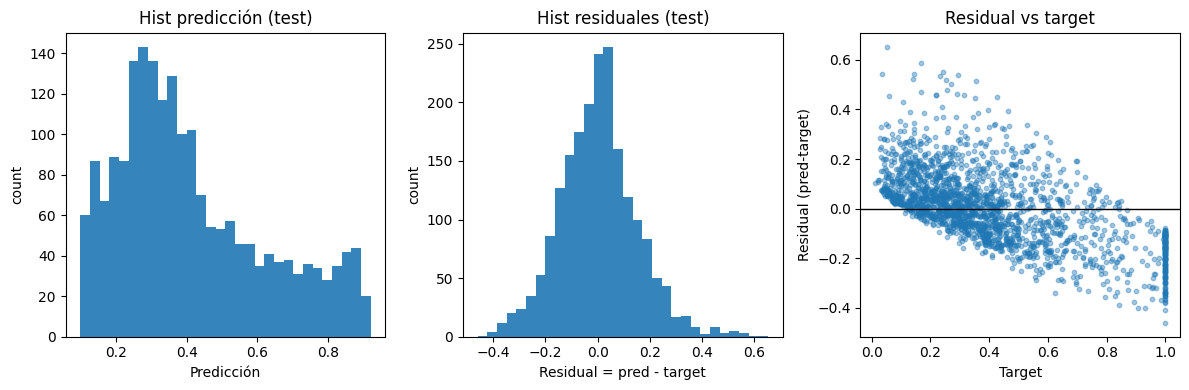

Test  MAE=0.1133   RMSE=0.1482   R²=0.6918


In [25]:
err = pt_flat - yt_flat
abs_err = np.abs(err)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(pt_flat, bins=30, alpha=0.9)
plt.xlabel("Predicción"); plt.ylabel("count"); plt.title("Hist predicción (test)")

plt.subplot(1,3,2)
plt.hist(err, bins=30, alpha=0.9)
plt.xlabel("Residual = pred - target"); plt.ylabel("count"); plt.title("Hist residuales (test)")

plt.subplot(1,3,3)
plt.scatter(yt_flat, err, s=10, alpha=0.4)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Target"); plt.ylabel("Residual (pred-target)"); plt.title("Residual vs target")
plt.tight_layout(); plt.show()

from sklearn.metrics import r2_score
print(f"Test  MAE={abs_err.mean():.4f}   RMSE={np.sqrt((err**2).mean()):.4f}   R²={r2_score(yt_flat, pt_flat):.4f}")


In [26]:
# from sklearn.metrics import confusion_matrix, classification_report

# TAU = 0.7
# y_bin_true = (yt_flat >= TAU).astype(int)
# y_bin_pred = (pt_flat >= TAU).astype(int)

# cm = confusion_matrix(y_bin_true, y_bin_pred, labels=[0,1])
# print(cm)
# print(classification_report(y_bin_true, y_bin_pred, digits=3))


In [27]:
# #Save model
# torch.save(model.state_dict(), "simple_cnn_weights.pth")


In [28]:
# import h5py
# import torch
# import numpy as np
# from tqdm import tqdm

# # ===== 1) Modelo =====
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SimpleCNN().to(device)
# model.load_state_dict(torch.load("simple_cnn_weights.pth", map_location=device))
# model.eval()

# # ===== 2) Leer H5 original (sin cargar todo si no quieres) =====
# H5_PATH = 'LSST_Mmxy_onlySubhalo_1e4to1e9_noiselessClean_fast_thr3p5.h5'
# with h5py.File(H5_PATH, 'r') as f:
#     N = f['images_rgb'].shape[0]
#     # maxval usado en entrenamiento (si existe; si no, será 1.0)
#     maxval = float(f['images_rgb'].attrs.get('maxval', 1.0))
#     # copia de atributos del archivo
#     file_attrs = dict(f.attrs)

# # ===== 3) Inferencia por lotes replicando el preprocesado del training =====
# batch_size = 128
# all_probs = np.empty((N,), dtype=np.float32)

# with h5py.File(H5_PATH, 'r') as f:
#     for start in tqdm(range(0, N, batch_size)):
#         end = min(N, start + batch_size)
#         # (B, H, W, 3) -> float32, normalizar como en training, -> (B, 3, H, W)
#         x = f['images_rgb'][start:end].astype('float32')
#         if maxval != 1.0:
#             x = x / maxval
#         x = np.transpose(x, (0, 3, 1, 2))

#         x_t = torch.from_numpy(x).to(device, non_blocking=True)
#         with torch.no_grad():
#             p = model(x_t)                    # (B,)
#             p = torch.sigmoid(p) if p.ndim == 0 else p  # por si el modelo devolviera logits
#         all_probs[start:end] = p.detach().cpu().numpy().astype(np.float32)

# # ===== 4) Selección por umbral =====
# THRESH = 0.5
# sel_idx = np.where(all_probs >= THRESH)[0]
# detectable_mask = np.zeros(N, dtype=bool)
# detectable_mask[sel_idx] = True

# print(f"Detectables: {sel_idx.size} / {N}")

# # ===== 5) Guardar el subconjunto preservando dtypes y attrs =====
# OUT_PATH = 'LSST_detectable_subset.h5'
# with h5py.File(H5_PATH, 'r') as fin, h5py.File(OUT_PATH, 'w') as fout:
#     # copiar datasets filtrando a lo largo del primer eje si coincide con N
#     for key in fin.keys():
#         dsrc = fin[key]
#         arr  = dsrc[()]
#         # si el dataset tiene primer eje N, filtramos; si no, lo copiamos tal cual
#         if arr.ndim >= 1 and arr.shape[0] == N:
#             arr_new = arr[detectable_mask]
#         else:
#             arr_new = arr

#         # siempre chunked si comprimimos
#         dnew = fout.create_dataset(
#             key,
#             data=arr_new,
#             dtype=arr.dtype,
#             chunks=True,
#             compression='gzip',
#             compression_opts=4
#         )
#         # copiar atributos del dataset
#         for ak, av in dsrc.attrs.items():
#             dnew.attrs[ak] = av

#     # guardar también las probabilidades y los índices seleccionados
#     fout.create_dataset('y_hat', data=all_probs, dtype='f4', chunks=True, compression='gzip', compression_opts=4)
#     fout.create_dataset('sel_idx', data=sel_idx.astype(np.int64), dtype='i8', chunks=True, compression='gzip', compression_opts=4)

#     # atributos del archivo (actualizados)
#     for k, v in file_attrs.items():
#         fout.attrs[k] = v
#     fout.attrs['description']      = 'Subset detectables según CNN (prob>=THRESH)'
#     fout.attrs['N_samples']        = int(sel_idx.size)          # actualiza al nuevo tamaño
#     fout.attrs['parent_N_samples'] = int(N)                     # tamaño del original
#     fout.attrs['clf_threshold']    = float(THRESH)
#     fout.attrs['clf_name']         = 'SimpleCNN'
